In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import digamma
%matplotlib inline
from ct_charachterization.utility.utils import central_gamma_pdf
from glob import glob
import pydicom as dicom
import dicom_numpy
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.stats import mode

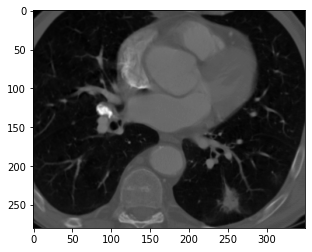

(280, 350)


In [2]:
img = np.load(f'''../resources/luna_cropped.npy''')
plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)

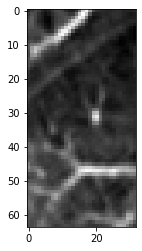

(64, 32)


In [36]:
neighborhood = img[150:214, :32]
plt.imshow(neighborhood, cmap='gray')
plt.show()
print(neighborhood.shape)

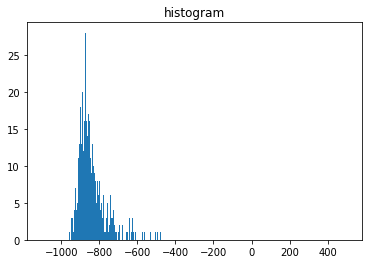

In [37]:
flat = neighborhood.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()

In [38]:
from scipy.stats import mode
mode(flat)

ModeResult(mode=array([-873], dtype=int16), count=array([28]))

In [39]:
delta = - 1030
mu = np.array([-987, -810, -540, -370, -160, 0, 100, 240, 340]) - delta
J = len(mu)

In [24]:
# initializing values

global_alpha = np.ones((J)) * 2
global_beta = np.array([mu[j]/global_alpha[j] for j in range(J)])
global_pi = np.ones((J)) / J

# local_alpha = np.ones((2, J)) * 2
# local_beta = np.expand_dims(mu, axis=0) / local_alpha
# local_pi = np.ones((2, J)) / J

In [81]:
y = np.expand_dims(neighborhood, axis=-1) - delta
alpha = np.expand_dims(np.expand_dims(global_alpha, axis=0), axis=0)
beta = np.expand_dims(np.expand_dims(global_beta, axis=0), axis=0)
pi = np.expand_dims(np.expand_dims(global_pi, axis=0), axis=0)
gamma = pi * central_gamma_pdf(y, alpha=alpha, beta=beta)

In [82]:
expanded_mu = np.expand_dims(np.expand_dims(mu, axis=0), axis=0)

In [83]:
right_hand_side = ((np.sum(gamma*y/expanded_mu, axis=(0,1)) - np.sum(gamma*np.log(y/expanded_mu), axis=(0,1))) / (np.sum(gamma, axis=(0,1)))) - 1

In [84]:
right_hand_side = np.expand_dims(np.expand_dims(right_hand_side, axis=0), axis=0)
print(right_hand_side.shape)

(1, 1, 9)


In [85]:
def _get_alphas_solution(right_hand_side, previous_alpha):
    alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
    alpha_solution = fsolve(alpha_optimizer, previous_alpha)
    return alpha_solution

vectorized_get_alphas_solution = np.vectorize(_get_alphas_solution)

In [94]:
err = np.Infinity
tol = 0.000001
n = 0
max_iter = 10
while err > tol and n < max_iter:
    n += 1
    new_alpha = vectorized_get_alphas_solution(right_hand_side, alpha)
    new_beta = expanded_mu / new_alpha
    new_pi = (np.sum(gamma, axis=(0,1))) / y.size
    err = np.linalg.norm(np.array([new_alpha.ravel(), new_beta.ravel(), new_pi.ravel()]) - np.array([alpha.ravel(), beta.ravel(), pi.ravel()])) / np.linalg.norm(np.array([alpha.ravel(), beta.ravel(), pi.ravel()]))
    gamma = pi * central_gamma_pdf(y, alpha=alpha, beta=beta)
    alpha = new_alpha
    beta = new_beta
    pi = new_pi
    print(n, err)

1 0.0


<ipython-input-85-b76b0093ae12>:2: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))


In [95]:
print(y.shape)

(64, 32, 1)


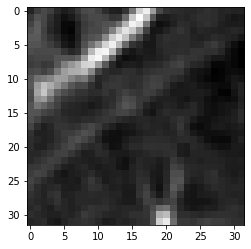

(32, 32, 1)


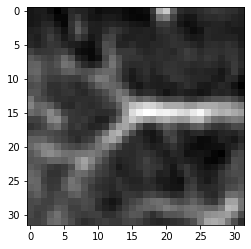

(32, 32, 1)


In [97]:
y_1 = y[0:32, :, :]
y_2 = y[32:64, :, :]

plt.imshow(y_1[:,:,0], cmap='gray')
plt.show()
print(y_1.shape)
plt.imshow(y_2[:,:,0], cmap='gray')
plt.show()
print(y_2.shape)

In [98]:
gamma_1 = pi * central_gamma_pdf(y_1, alpha=alpha, beta=beta)
gamma_2 = pi * central_gamma_pdf(y_2, alpha=alpha, beta=beta)

In [100]:
right_hand_side_1 = ((np.sum(gamma_1*y_1/expanded_mu, axis=(0,1)) - np.sum(gamma_1*np.log(y_1/expanded_mu), axis=(0,1))) / (np.sum(gamma_1, axis=(0,1)))) - 1
right_hand_side_2 = ((np.sum(gamma_2*y_2/expanded_mu, axis=(0,1)) - np.sum(gamma_2*np.log(y_2/expanded_mu), axis=(0,1))) / (np.sum(gamma_2, axis=(0,1)))) - 1
right_hand_side_1 = np.expand_dims(np.expand_dims(right_hand_side_1, axis=0), axis=0)
right_hand_side_2 = np.expand_dims(np.expand_dims(right_hand_side_2, axis=0), axis=0)

In [101]:
from copy import deepcopy

err = np.Infinity
tol = 0.000001
n = 0
max_iter = 10
alpha_1 = deepcopy(alpha)
beta_1 = deepcopy(beta)
pi_1 = deepcopy(pi)

while err > tol and n < max_iter:
    n += 1
    new_alpha_1 = vectorized_get_alphas_solution(right_hand_side_1, alpha_1)
    new_beta_1 = expanded_mu / new_alpha_1
    new_pi_1 = (np.sum(gamma_1, axis=(0,1))) / y_1.size
    err = np.linalg.norm(np.array([new_alpha_1.ravel(), new_beta_1.ravel(), new_pi_1.ravel()]) - np.array([alpha_1.ravel(), beta_1.ravel(), pi_1.ravel()])) / np.linalg.norm(np.array([alpha_1.ravel(), beta_1.ravel(), pi_1.ravel()]))
    gamma_1 = pi_1 * central_gamma_pdf(y_1, alpha=alpha_1, beta=beta_1)
    alpha_1 = new_alpha_1
    beta_1 = new_beta_1
    pi_1 = new_pi_1
    print(n, err)
    
err = np.Infinity
tol = 0.000001
n = 0
max_iter = 10
alpha_2 = deepcopy(alpha)
beta_2 = deepcopy(beta)
pi_2 = deepcopy(pi)

while err > tol and n < max_iter:
    n += 1
    new_alpha_2 = vectorized_get_alphas_solution(right_hand_side_2, alpha_2)
    new_beta_2 = expanded_mu / new_alpha_2
    new_pi_2 = (np.sum(gamma_2, axis=(0,1))) / y_2.size
    err = np.linalg.norm(np.array([new_alpha_2.ravel(), new_beta_2.ravel(), new_pi_2.ravel()]) - np.array([alpha_2.ravel(), beta_2.ravel(), pi_2.ravel()])) / np.linalg.norm(np.array([alpha_2.ravel(), beta_2.ravel(), pi_2.ravel()]))
    gamma_2 = pi_2 * central_gamma_pdf(y_2, alpha=alpha_2, beta=beta_2)
    alpha_2 = new_alpha_2
    beta_2 = new_beta_2
    pi_2 = new_pi_2
    print(n, err)


1 0.12037890170708106
2 1.2318988245897907e-16
1 0.055651202772056395
2 1.9051012964770105e-14


<ipython-input-85-b76b0093ae12>:2: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))


-1008 -987


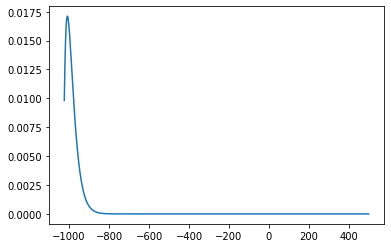

-841 -810


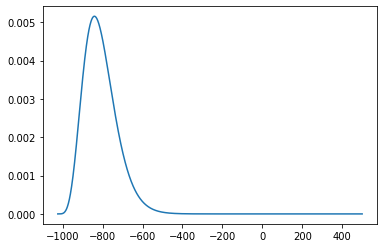

-877 -540


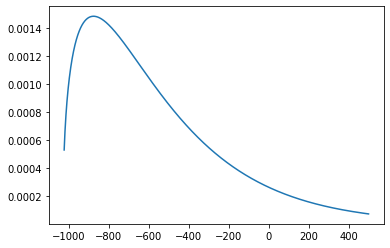

-1011 -370


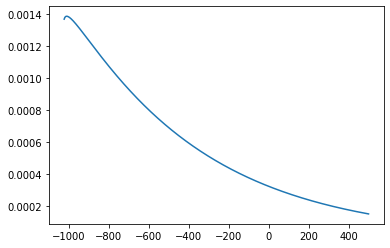

-595 -160


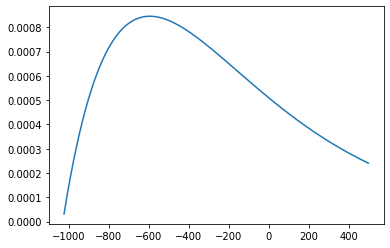

-515 0


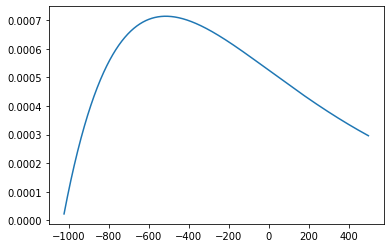

-465 100


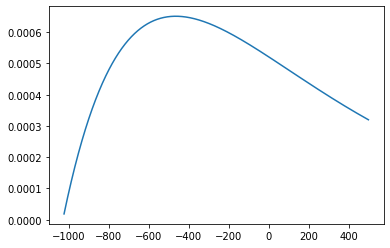

-395 240


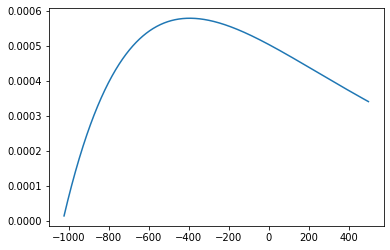

-345 340


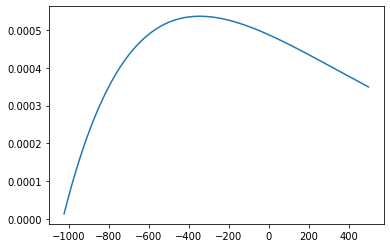

In [103]:
for j in range(J):
    wanted_alpha = alpha[0, 0, j]
    wanted_beta = beta[0, 0, j]
    xs = np.arange(-1024, 500, 1) + 1030
    ys = central_gamma_pdf(xs, wanted_alpha, wanted_beta).ravel()
    plt.plot(xs - 1030, ys, '-')
    print(xs[np.argmax(ys)] -1030, mu[j] - 1030)
    plt.show()

In [112]:
constant_c = 10
first_local_moment_numerator_1 = np.sum(np.log(y_1)*gamma_1, axis=(0,1))
first_local_moment_numerator_2 = np.sum(np.log(y_2)*gamma_2, axis=(0,1))
second_local_moment_numerator_1 = np.sum(y_1*gamma_1, axis=(0,1))
second_local_moment_numerator_2 = np.sum(y_2*gamma_2, axis=(0,1))
denumerator_1 = np.sum(gamma_1, axis=(0,1))
denumerator_2 = np.sum(gamma_2, axis=(0,1))
first_local_moment_1 = first_local_moment_numerator_1 / denumerator_1
first_local_moment_2 = first_local_moment_numerator_2 / denumerator_2
second_local_moment_1 = second_local_moment_numerator_1 / denumerator_1
second_local_moment_2 = second_local_moment_numerator_2 / denumerator_2
var_1 = second_local_moment_1 - np.power(first_local_moment_1, 2)
var_2 = second_local_moment_2 - np.power(first_local_moment_2, 2)
y_stab_1 = (constant_c * (np.expand_dims(np.log(y_1), axis=-1) - first_local_moment_1) / np.sqrt(var_1)) + second_local_moment_1
y_stab_2 = (constant_c * (np.expand_dims(np.log(y_2), axis=-1) - first_local_moment_2) / np.sqrt(var_2)) + second_local_moment_2

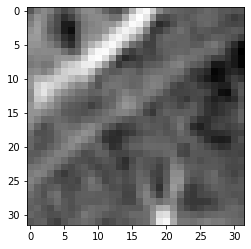

114.62891340154745 115.51210242612426 116.85208062431336


In [118]:
to_show = y_stab_1[..., 0]
plt.imshow(to_show, cmap='gray')
plt.show()
print(np.min(to_show), np.mean(to_show), np.max(to_show))

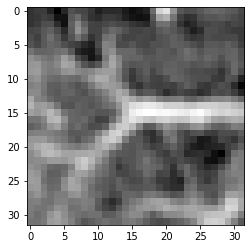

146.6770248698232 147.33969460595011 148.23335974212037


In [119]:
to_show = y_stab_2[..., 0]
plt.imshow(to_show, cmap='gray')
plt.show()
print(np.min(to_show), np.mean(to_show), np.max(to_show))

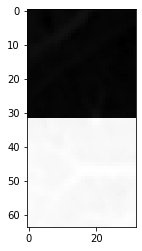

517


In [120]:
y_stab = np.empty(tuple(list(y.shape) + [J]))
y_stab[0:32, ...] = y_stab_1
y_stab[32:64, ...] = y_stab_2

plt.imshow(y_stab[..., 0], cmap='gray')
plt.show()
print(len(np.unique(y_stab[..., 0])))